In [114]:
import os
import glob
import math
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import clima_anom as ca
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%run ../function/function.ipynb

In [115]:
shape = list(shpreader.Reader('../mappings/SaoPaulo_Fixed.shp').geometries())

In [116]:
Brasildat_dir = '/media/arturo/Arturo/Datos/BrasilDat/SP/BrasilDat_2018_03_5min_8kmx8km.nc'
Brasildat = ca.read_netcdf(Brasildat_dir,2)
lat = Brasildat['lat']
lon = Brasildat['lon']
time_B = Brasildat['time']
flash_B = Brasildat['flash']

lon2d, lat2d = np.meshgrid(lon,lat)
nt, ny, nx = np.shape(flash_B)

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


In [117]:
GLM_dir = '/media/arturo/Arturo/Datos/GLM/SP/GLM_2018_03_5min_8kmx8km.nc'
GLM = ca.read_netcdf(GLM_dir,2)
flash_G = GLM['flash']

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


## Cleaning data

In [118]:
lat_c = -22.8611
lon_c = -47.0563
r = (180)/111

In [119]:
Area_R = np.zeros([ny,nx])
for i in range(ny):
    for j in range(nx):
        Dist = distancia(lat_c,lon_c,lat[i],lon[j])
        if Dist <= 162:
            Area_R[i,j] = 1

In [120]:
G_new = np.zeros([nt,ny,nx])
B_new = np.zeros([nt,ny,nx])
for t in range(nt):
    for i in range(ny):
        for j in range(nx):
            if Area_R[i,j] == 1:
                G_new[t,i,j] = flash_G[t,i,j]
                B_new[t,i,j] = flash_B[t,i,j]
            else:
                G_new[t,i,j] = np.nan
                B_new[t,i,j] = np.nan

## 15 mintues accumulated

In [124]:
ntime = int(nt/3)
print(ntime)
flash_B_15 = np.zeros([ntime, ny, nx])
flash_G_15 = np.zeros([ntime, ny, nx])
for t in range(ntime):
    # print(t,3*t,3*t+3)
    flash_B_15[t,:,:] = np.sum(B_new[3*t:3*t+3,:,:],axis=0)
    flash_G_15[t,:,:] = np.sum(G_new[3*t:3*t+3,:,:],axis=0)

2976


In [122]:
flash_G_15_serie = np.reshape(flash_G_15,(ntime*ny*nx))
flash_B_15_serie = np.reshape(flash_B_15,(ntime*ny*nx))

## Scatter plot

In [105]:
Regresion = np.zeros([3])

X_train, X_test, y_train, y_test = train_test_split(flash_G_15_serie,flash_B_15_serie, train_size = 0.9,random_state = 1234,shuffle = True)
corr_test = pearsonr(flash_G_15_serie,flash_B_15_serie)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

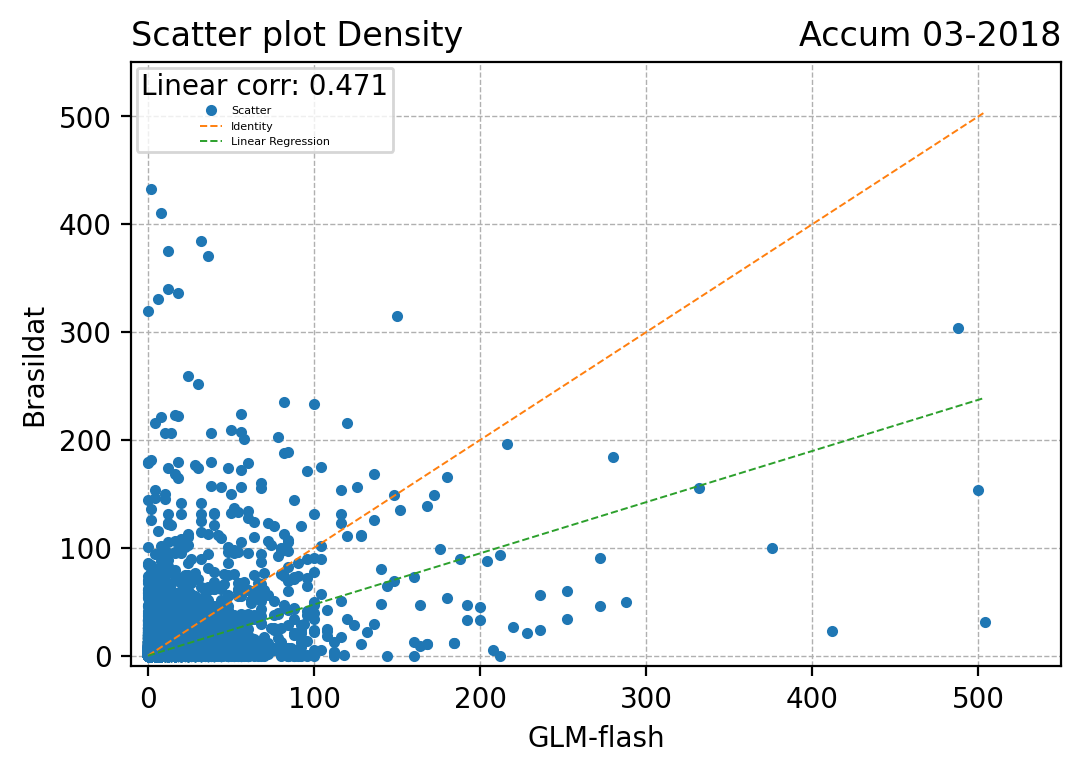

In [109]:
xx = np.arange(0,np.max(flash_G_15_serie))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(flash_G_15_serie,flash_B_15_serie,'.',label='Scatter')
ax1.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax1.plot(xx,yy_regretion,'--',linewidth=0.7,label='Linear Regression')

ax1.set_ylim(-10,550)
ax1.set_xlim(-10,550)

ax1.set_ylabel('Brasildat')
ax1.set_xlabel('GLM-flash')
ax1.set_title('Scatter plot Density',loc='left')
ax1.set_title('Accum 03-2018',loc='right')

leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax1.legend(title=leg_title,loc=2, fontsize=4)
plt.grid(linewidth=0.5,linestyle='--')

salida = '../images/Scatter_GLM_BrasilDat_15min_month_accum.png'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## Export netcdf

In [127]:
print(f'Brasildat shape: {flash_B_15.shape}')
info = {'file': '/media/arturo/Arturo/Datos/BrasilDat/SP/BrasilDat_2018_03_15min_8kmx8km.nc', # filename and directory
        'title': 'Brasildat data 8km x 8km', # netcdf title
        'year_start':2018,'month_start':3,'day_start':1,'hour_start':0,'minute_start':0, # time start (year,month,day,hour,minute)
        'year_end':2018,'month_end':3,'day_end':31,'hour_end':23,'minute_end':59, # time end (year,month,day,hour,minute)
        'time_frequency': 'Minutely', # options: Monthly, Daily, Hourly, Minutely
        'time_interval':15,
        'var_name': 'flash', # variable short name
        'var_units': 'flash/196km2'} # variable units

Brasildat shape: (2976, 45, 45)


In [128]:
ca.create_netcdf(info,flash_B_15,lat,lon)

Time Start: 2018-03-01 00:00:00
Time End: 2018-03-31 23:45:00
Time Frequency: Minutely
Time Lenght: 2976

File created in:  /media/arturo/Arturo/Datos/BrasilDat/SP/BrasilDat_2018_03_15min_8kmx8km.nc
File title:  Brasildat data 8km x 8km
var title:  flash
var units:  flash/196km2


In [129]:
print(f'Brasildat shape: {flash_G_15.shape}')
info = {'file': '/media/arturo/Arturo/Datos/GLM/SP/GLM_2018_03_15min_8kmx8km.nc', # filename and directory
        'title': 'GLM-flash data 8km x 8km', # netcdf title
        'year_start':2018,'month_start':3,'day_start':1,'hour_start':0,'minute_start':0, # time start (year,month,day,hour,minute)
        'year_end':2018,'month_end':3,'day_end':31,'hour_end':23,'minute_end':59, # time end (year,month,day,hour,minute)
        'time_frequency': 'Minutely', # options: Monthly, Daily, Hourly, Minutely
        'time_interval':15,
        'var_name': 'flash', # variable short name
        'var_units': 'flash/196km2'} # variable units

Brasildat shape: (2976, 45, 45)


In [130]:
ca.create_netcdf(info,flash_G_15,lat,lon)

Time Start: 2018-03-01 00:00:00
Time End: 2018-03-31 23:45:00
Time Frequency: Minutely
Time Lenght: 2976

File created in:  /media/arturo/Arturo/Datos/GLM/SP/GLM_2018_03_15min_8kmx8km.nc
File title:  GLM-flash data 8km x 8km
var title:  flash
var units:  flash/196km2
